### Imports

In [1]:
import numpy as np                             # numerical methods
import pandas as pd                            # tabular data
import seaborn as sns                          # plotting
import missingno as msno                       # handling missing data
import plotly.express as px                    # plotting
import matplotlib.pyplot as plt                # plotting
from datetime import date, timedelta           # handling datetime objects 
from plotly.subplots import make_subplots      # plotting
from scipy.stats import chi2, chi2_contingency # statistical analysis

### Preprocessing

In [2]:
raw = pd.read_parquet('escooter_history.parquet')

In [3]:
# create copy
df = raw.copy()

# fix data types
df = df.astype({
    "holiday": "boolean",
    "workingday": "boolean",
    "weather": "category"
})
# fix typo in weather
df.weather.cat.rename_categories(
    {"heacy rain or thunderstorm or snow or ice pallets": "heavy rain or thunderstorm or snow or ice pallets"}, inplace=True
)

# add shortcut to datetime.dt
dt = df["datetime"].dt

# add day and month name as new column
df["weekday"] = dt.day_name(locale="german")
df["month"] = dt.month_name(locale="german")
df["month_p"] = dt.to_period("M").astype("str")
df["quarter"] =  dt.to_period("Q").astype("str")



## Jenny & Anna

<AxesSubplot:ylabel='Stunde'>

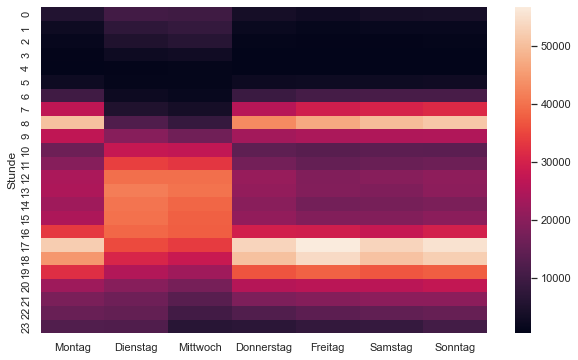

In [4]:
# create new DataFrame from dates
df_weekday = df[["datetime", "weekday"]].copy()
# save order as list
weekdays = ["Montag", "Dienstag", "Mittwoch", "Donnerstag", "Freitag", "Samstag", "Sonntag"]
# create dummies for weekday and group by hour, counting occurences of each day-hour combination
df_weekday = pd.get_dummies(df_weekday, prefix="", prefix_sep="").groupby(df_weekday["datetime"].dt.hour).agg({day: "sum" for day in weekdays})
# rename index
df_weekday.index.rename("Stunde", inplace = True)
# set figure size and display heatmap
sns.set(rc={'figure.figsize':(10,6)})
sns.heatmap(df_weekday)

<AxesSubplot:xlabel='Anzahl an Ausleihungen je Zeitraum', ylabel='Zeitraum'>

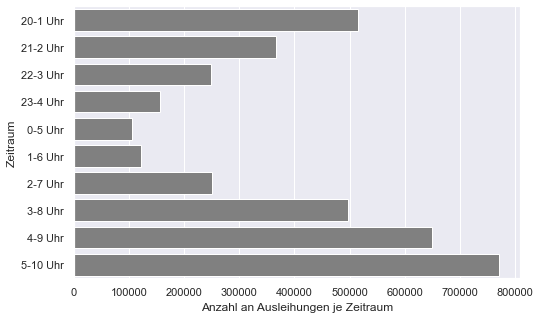

In [5]:
# keep track of interesting timeslots
slots = [[20,21,22,23,0,1], [21,22,23,0,1,2], [22,23,0,1,2,3], [23,0,1,2,3,4], *[[*range(start, start+6)] for start in range(6)]]
# create dataframe mapping slot to number of rentals in slot
df_timeslot = pd.DataFrame({"Zeitraum": [f"{slot[0]}-{slot[-1]} Uhr" for slot in slots],
                            "Anzahl an Ausleihungen je Zeitraum": [len(df.loc[dt.hour.isin(slot)]) for slot in slots]})
# display as horizontal bar chart
sns.set(rc={'figure.figsize':(8,5)})
sns.barplot(x=df_timeslot['Anzahl an Ausleihungen je Zeitraum'], y=df_timeslot["Zeitraum"], color='grey') 

## Torben

### Erkenntnis: Überwiegend gutes Wetter

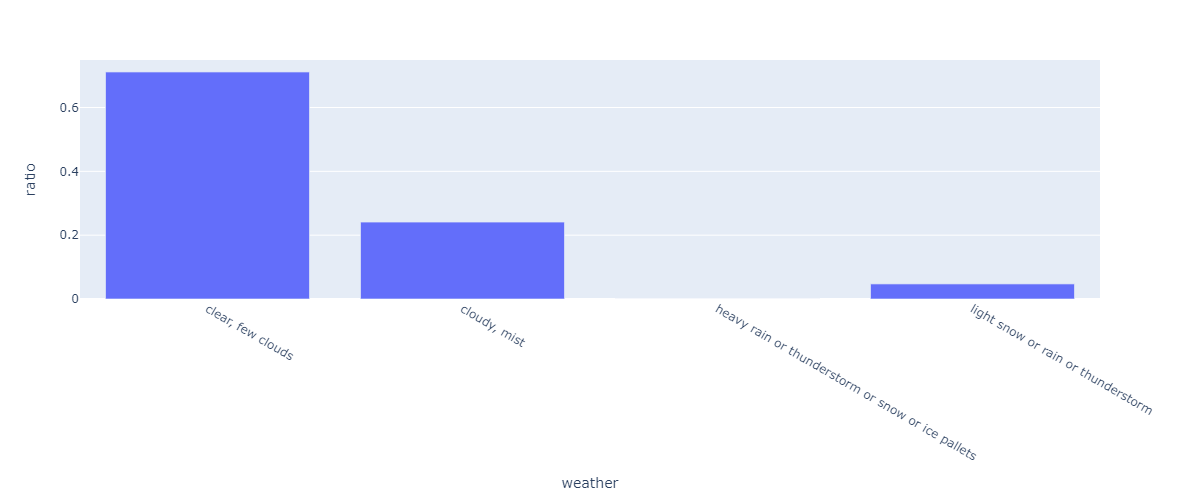

In [6]:
# groupby weather and count occurences
df_weather = df.groupby("weather", as_index=False)[['datetime']].count()
# compute ratio
df_weather['ratio'] = df_weather.datetime/df_weather.datetime.sum()
# display as bar chart
px.bar(df_weather, x = 'weather',y = 'ratio', width=600, height=500)

## Relative Häufigkeiten

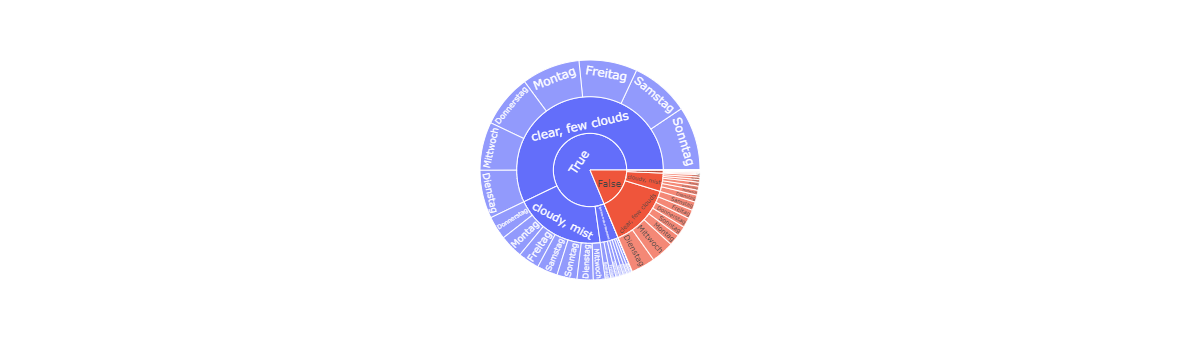

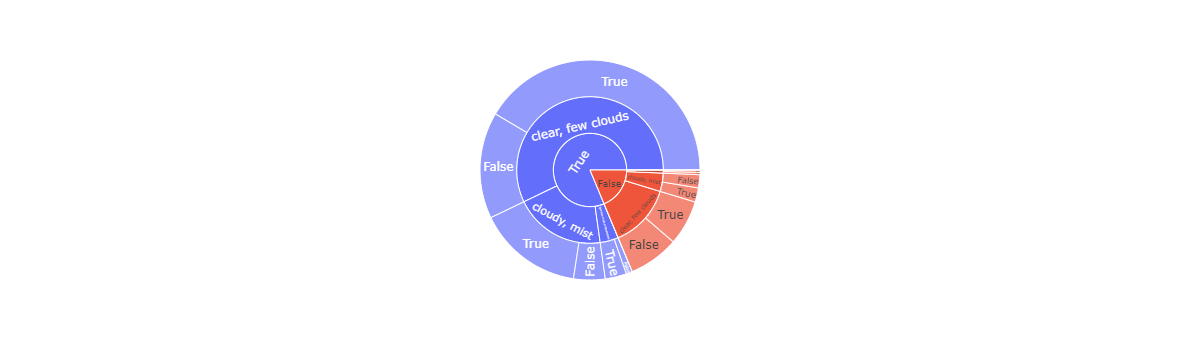

In [7]:
# create sunburst plots
display(px.sunburst(df, path=['registered_customer', 'weather', 'weekday']), width=400, height=400)
display(px.sunburst(df, path=['registered_customer', 'weather', 'workingday']), width=400, height=400)

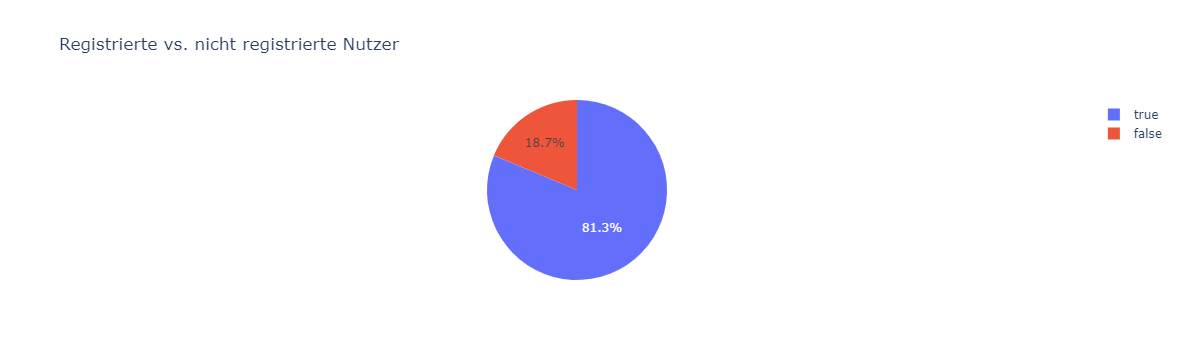

In [8]:
# group by registered customer
df_agg = df.groupby('registered_customer', as_index=False)[['datetime']].count()
# rename columns
df_agg.columns = ['registered_customer', 'count']
# display pie chart
px.pie(df_agg, values='count', names='registered_customer', title='Registrierte vs. nicht registrierte Nutzer', width=400, height=300)

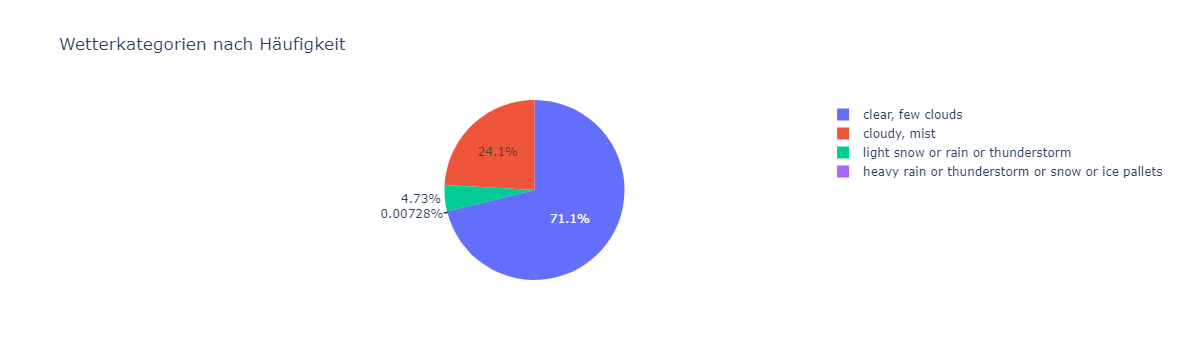

In [9]:
# group by weather
df_agg = df.groupby('weather', as_index=False)[['datetime']].count()
# rename columns
df_agg.columns = ['weather', 'count']
# display pie chart
px.pie(df_agg, values='count', names='weather', title= 'Wetterkategorien nach Häufigkeit', width=600, height=300)

## 2. Block: Nutzungsverhalten Feiertage/Wochenende vs. Workday

In [10]:
# conduct chi^2 for weather - registered customer relationship
weather_stats = chi2_contingency(pd.crosstab(df['weather'], df['registered_customer'], margins=True, normalize = False), correction=False)
# conduct chi^2 for holiday - registered customer relationship
holiday_stats = chi2_contingency(pd.crosstab(df['holiday'], df['registered_customer'], margins=True, normalize = False), correction=False)
# conduct chi^2 for working day - registered customer relationship
wday_stats = chi2_contingency(pd.crosstab(raw['workingday'], raw['registered_customer'], margins=True, normalize = False), correction=False)
# save in DataFrame
df_stats = pd.DataFrame([
    ["Abhängigkeit zwischen Werktag & ob Kunde registriert", *wday_stats],
    ["Abhängigkeit zwischen Feiertag & ob Kunde registriert", *holiday_stats],
    ["Abhängigkeit zwischen Wetter & ob Kunde registriert", *weather_stats]])
# rename columns
df_stats.columns = ["Zusammenhang", "Teststatistik", "p-Wert", "Freiheitsgrade", "Signifikant"]
# add column Signifikant
df_stats["Signifikant"] = df_stats["p-Wert"] < 0.05

In [11]:
# Abhängigkeit zwischen reg_customer & workingday signifikant
df_stats.loc[[0]]

Zusammenhang  Teststatistik  p-Wert  \
0  Abhängigkeit zwischen Werktag & ob Kunde regis...  153121.729287     0.0   

   Freiheitsgrade  Signifikant  
0               4         True

In [12]:
# CrossTab holiday/Workingday: Am Wochentagen pendeln mehr Leute, Am Wochenende/Feiertagen mehr unregistered!
df.groupby("registered_customer").mean()

holiday  workingday       temp      atemp   humidity  \
registered_customer                                                          
False                0.036889    0.483971  25.375371  29.167350  53.144846   
True                 0.024828    0.739221  22.823022  26.432777  57.484324   

                     windspeed  
registered_customer             
False                13.853585  
True                 13.348152

# TORBEN HIER HALLO
# was ist das wieso geht es bis 2
# BITTE DAS HIER LÖSCHEN VOR DER PRÄSENTATION

<AxesSubplot:xlabel='workingday', ylabel='count'>

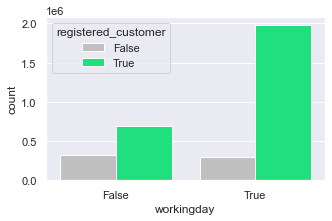

In [13]:
# Interessant: Nicht registrierte Nutzer fahren in der Summe fast genauso häufig am Wochenende wie an Arbeitsagen
# -> Demnach deutlich häufiger am Wochende/Feiertagen, da es ja weniger freie Tage als Werktage gibt!
sns.set(rc={'figure.figsize':(5,3)})
sns.countplot(data=df, x='workingday', hue='registered_customer', palette={False:'silver',True:'springgreen'})

### Gleiches Spiel für Werktage

In [14]:
pd.crosstab(raw['holiday'], raw['registered_customer'], margins=True, normalize = True)

registered_customer     False      True       All
holiday                                          
0                    0.180245  0.792669  0.972915
1                    0.006904  0.020182  0.027085
All                  0.187149  0.812851  1.000000

In [15]:
# Abhängigkeit zwischen reg_customer & holiday ist auch signifikant
df_stats.loc[[1]]

Zusammenhang  Teststatistik  p-Wert  \
1  Abhängigkeit zwischen Feiertag & ob Kunde regi...    2767.884787     0.0   

   Freiheitsgrade  Signifikant  
1               4         True

<AxesSubplot:xlabel='holiday', ylabel='count'>

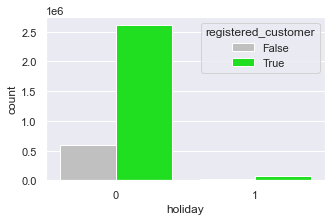

In [16]:
# Visualisierung sinnlos, da geringe Anzahl Holidays -> Falls Block Holiday in Bericht, dann erwähnen der geringen 
# Fallzahl Holiday und somit reduzierte Aussagekraft
sns.countplot(data=raw, x='holiday', hue='registered_customer', palette={False:'silver',True:'lime'})

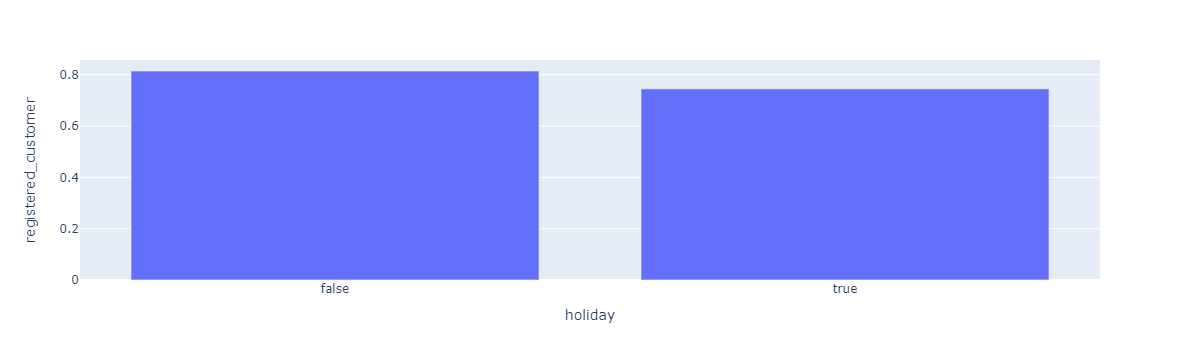

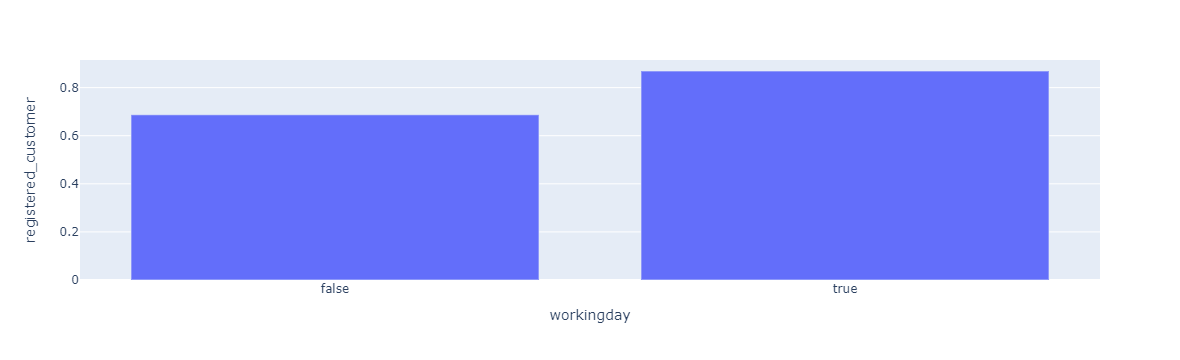

In [17]:
# display bar charts showing share of registered customers on holidays vs weekdays
display(px.bar(df.groupby("holiday", as_index=False)[['registered_customer']].mean(),
               x = 'holiday',y = 'registered_customer', width=400, height=300))
display(px.bar(df.groupby("workingday", as_index=False)[['registered_customer']].mean(),
               x = 'workingday',y = 'registered_customer', width=400, height=300))

## Gleiches Spiel für Wetter

In [18]:
# Column registered_customer: Grafik -> Nutzungsverhalten nach Wetterkategorien ! Aufpassen bei heavy rain: Nur 240 Fälle!
# hoher Wert von .96 daher auch nicht besonders Aussagekräftig
# Kurz Profil der 4 Weatherconditions darstellen?
df_weather = raw.groupby("weather",as_index=False)[['datetime']].count()
df_weather.columns = ['weather', 'count']
df_weather

weather    count
0                                  clear, few clouds  2344884
1                                       cloudy, mist   794925
2  heacy rain or thunderstorm or snow or ice pallets      240
3                 light snow or rain or thunderstorm   155972

In [19]:
# -> Je schlechter das Wetter, desto größer der Anteil an reg. Nutzern
pd.crosstab(df['weather'], df['registered_customer'], margins=True, normalize = True)

registered_customer                                   False      True  \
weather                                                                 
clear, few clouds                                  0.140094  0.571335   
cloudy, mist                                       0.040245  0.200932   
heavy rain or thunderstorm or snow or ice pallets  0.000003  0.000070   
light snow or rain or thunderstorm                 0.006807  0.040515   
All                                                0.187149  0.812851   

registered_customer                                     All  
weather                                                      
clear, few clouds                                  0.711429  
cloudy, mist                                       0.241177  
heavy rain or thunderstorm or snow or ice pallets  0.000073  
light snow or rain or thunderstorm                 0.047321  
All                                                1.000000

In [20]:
# Abhängigkeit zwischen reg_customer & Wetterlage ist signifikant --> je schlechter das Wetter, desto größer der Anteil
# registrierter Nutzer

df_stats.loc[[2]]

Zusammenhang  Teststatistik  p-Wert  \
2  Abhängigkeit zwischen Wetter & ob Kunde regist...    5578.580022     0.0   

   Freiheitsgrade  Signifikant  
2               8         True

## Lena

In [21]:
# explore duplicates
print(f"Von {len(df)} Datumswerten sind {df.datetime.nunique()} einzigartig, es doppeln sich also {len(df)-df.datetime.nunique()}.")
print(f"Jedes Duplikat ist dabei maximal {df.groupby('datetime')['temp'].count().max()} Mal vorhanden.")

Von 3296021 Datumswerten sind 3138526 einzigartig, es doppeln sich also 157495.
Jedes Duplikat ist dabei maximal 5 Mal vorhanden.


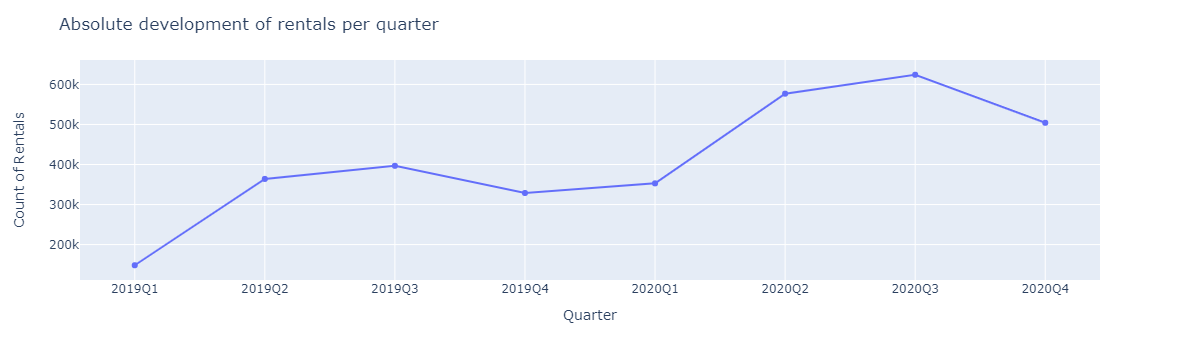

In [22]:
# draw lineplot of count grouped by quarter
fig = px.line(df.groupby("quarter",as_index=False).count(), x="quarter", y="registered_customer", markers=True)
fig.update_layout(title="Absolute development of rentals per quarter", xaxis_title="Quarter", yaxis_title="Count of Rentals")

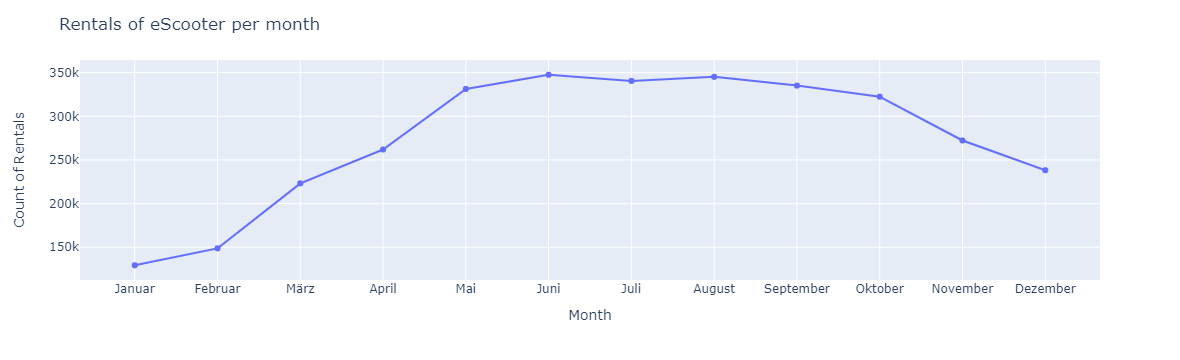

In [23]:
# draw lineplot of count grouped by month
fig = px.line(df.groupby("month",as_index=False, sort=False).count(), x="month", y="temp", markers=True)
fig.update_layout( title="Rentals of eScooter per month", xaxis_title="Month", yaxis_title="Count of Rentals")

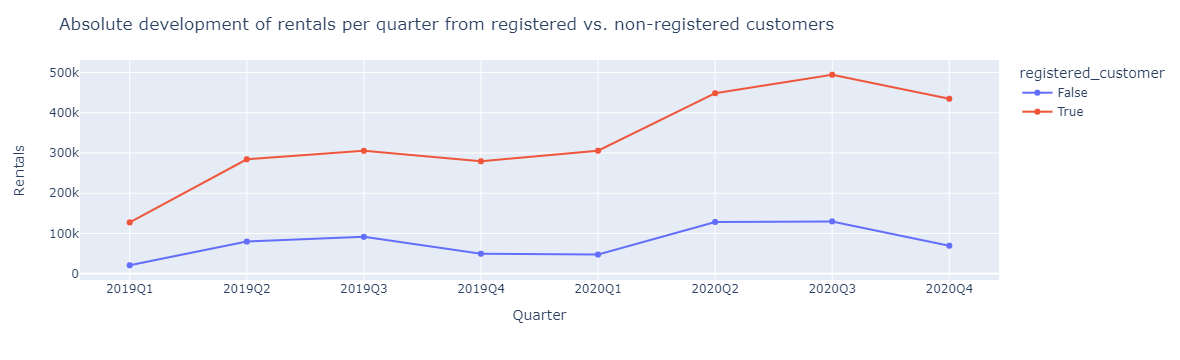

In [24]:
# show rentals of registered vs non-registered customers per quarter 
fig_rents_per_quarter_pc = px.line(df.groupby(["quarter","registered_customer"],as_index=False).count(), x="quarter", y="temp", color="registered_customer", markers=True)
fig_rents_per_quarter_pc.update_layout(title="Absolute development of rentals per quarter from registered vs. non-registered customers", xaxis_title="Quarter", yaxis_title="Rentals")

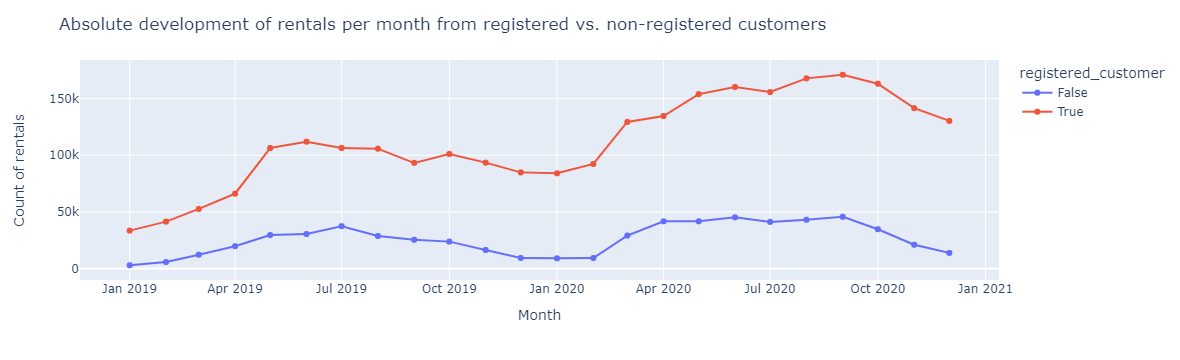

In [25]:
# show rentals of registered vs non-registered customers per month 
fig = px.line(df.groupby(["month_p","registered_customer"],as_index=False).count(), x="month_p", y="temp", color="registered_customer", markers=True)
fig.update_layout(title="Absolute development of rentals per month from registered vs. non-registered customers", xaxis_title="Month", yaxis_title="Count of rentals")

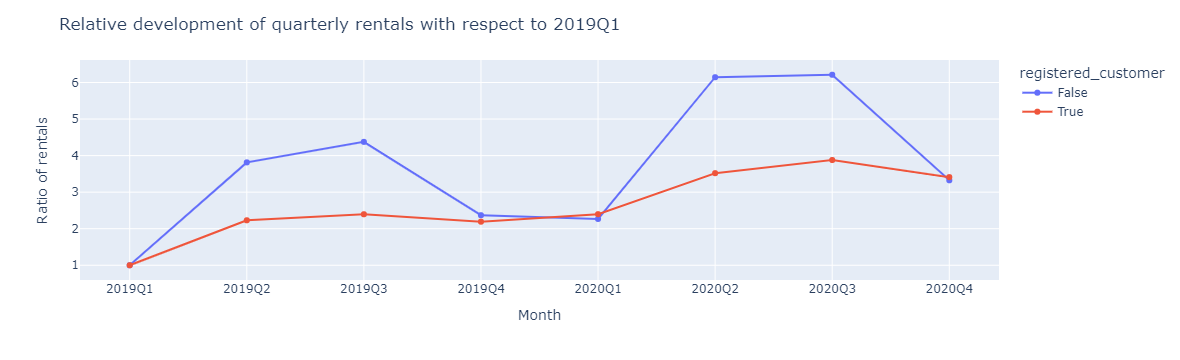

In [27]:
# group by quarter and registered customer
df_ratio = df.groupby(["quarter", "registered_customer"], as_index=False).count()
# establish baseline
baseline_0, baseline_1 = (df_ratio.iloc[0][2], df_ratio.iloc[1][2])
# compute ratio relative to baseline
df_ratio["ratio"] = df_ratio["temp"].where(df_ratio["registered_customer"], df_ratio["temp"]/baseline_0)
df_ratio["ratio"] = df_ratio["ratio"].where(~df_ratio["registered_customer"], df_ratio["temp"]/baseline_1)

# display line plot
fig = px.line(df_ratio, x="quarter", y="ratio", color="registered_customer", markers=True)
fig.update_layout( title="Relative development of quarterly rentals with respect to 2019Q1", xaxis_title="Month", yaxis_title="Ratio of rentals")

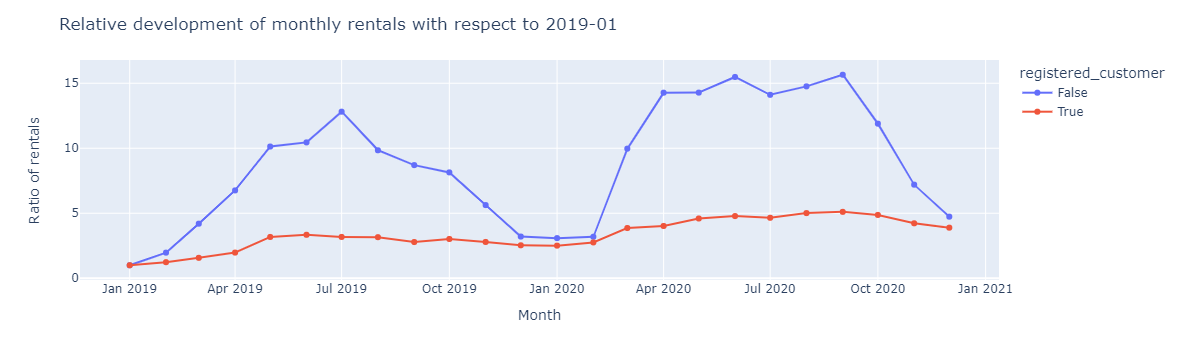

In [29]:
# group by month and registered customer
df_ratio = df.groupby(["month_p", "registered_customer"], as_index=False).count()
# establish baseline
baseline_0, baseline_1 = (df_ratio.iloc[0][2], df_ratio.iloc[1][2])
# compute ratio relative to baseline
df_ratio["ratio"] = df_ratio["temp"].where(df_ratio["registered_customer"], df_ratio["temp"]/baseline_0)
df_ratio["ratio"] = df_ratio["ratio"].where(~df_ratio["registered_customer"], df_ratio["temp"]/baseline_1)

# display line plot
fig = px.line(df_ratio, x="month_p", y="ratio", color="registered_customer", markers=True)
fig.update_layout( title="Relative development of monthly rentals with respect to 2019-01", xaxis_title="Month", yaxis_title="Ratio of rentals")

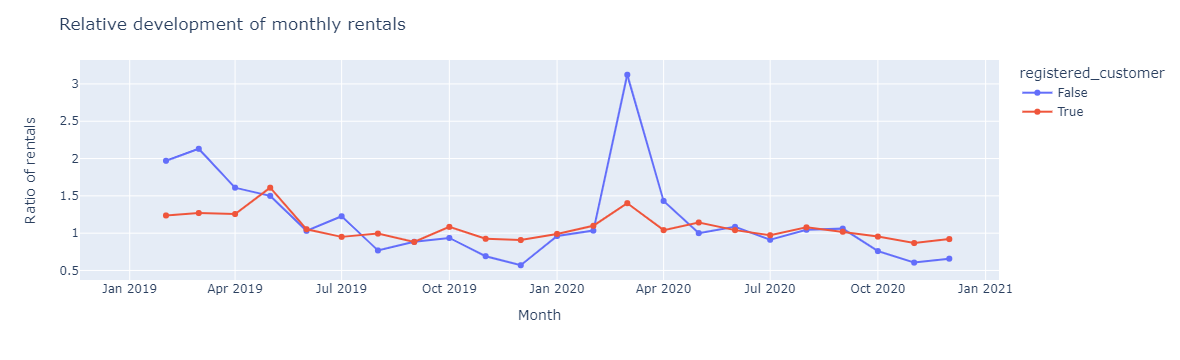

In [30]:
# group by month and registered customer
df_ratio = df.groupby(["month_p", "registered_customer"], as_index=False).count()
# compute ratio
df_ratio["ratio"] = df_ratio["temp"] / df_ratio["temp"].shift(2)

# display line plot
fig = px.line(df_ratio, x="month_p", y="ratio", color="registered_customer", markers=True)
fig.update_layout( title="Relative development of monthly rentals", xaxis_title="Month", yaxis_title="Ratio of rentals")